## Data loading for default of credit card clients dataset 

To use the data, simply load the pickle file

In [1]:
import pickle
import numpy as np
import pdb
import matplotlib.pyplot as plt
with open("train_test_split.pkl", "br") as fh:
    data = pickle.load(fh)
train_data = data[0]
test_data = data[1]

train_x = train_data[:,:23]
train_y = train_data[:,23] # labels are either 0 or 1
test_x = test_data[:,:23]
test_y = test_data[:,23] # labels are either 0 or 1

# converting the labels to +-1 

In [2]:
train_y = 2*train_y - 1
test_y = 2*test_y -1

# weak classifier

# Parallel Ada Boost Algorithm-1

In [6]:
class Adaboost:
    def __init__(self, train_x, train_y,test_x,test_y):
        self.train_x = train_x 
        self.train_y = train_y
        self.test_x =  test_x
        self.test_y = test_y
        self.feature_len = self.train_x.shape[1]
        self.train_len = self.train_x.shape[0]
        self.test_len =  self.test_x.shape[0]
        
        # weak classifiers is pre-defined : we designed weak classifier based on training set
        self.h_weak_train , self.model_median = self.naive_weak_classifier(self.train_x,j=None,train_data=True)
        self.M_train,self.M_train_normalized = self.cal_M(self.h_weak_train , train_data=True)
        #pdb.set_trace()
        # For testing set we use self.modele_median 
        self.h_weak_test,_  = self.naive_weak_classifier(self.test_x,j=None, train_data = False)
        self.M_test,self.M_test_normalized = self.cal_M(self.h_weak_test , train_data=False)
    
    # h_j = sign(x_j-m_j)
    def naive_weak_classifier(self,X,j=None,train_data=True):
        #X : nxd 
        #j : jth feature <=d if none then comute H_j = n*d matrix
        # return 
        # h_j = nx1 classifier or H_j  = n*d matrix  
        if j != None:
            X_j = X[:,j]
            if train_data != True:
                M_j  = self.model_median[j]
            else:
                M_j = np.median(X_j) 
            h_j_temp  = X_j - M_j
            h_j  = np.where(h_j_temp >= 0, 1, -1)[...,np.newaxis]
            return h_j
        else :
            if train_data == False:
                M = self.model_median  # implies the given data is test data , we will use the computed median from the training data , since this is a parameter
            else:
               M = np.median(X,axis=0)[np.newaxis,...]
            #print(M.shape) 
            H_j_temp  = X - M
            H  = np.where(H_j_temp >= 0, 1, -1)
            return H,M
    def cal_loss(self,w_t):
        #pdb.set_trace()
        H_train = np.multiply(w_t.squeeze(),self.h_weak_train)
        H_test = np.multiply(w_t.squeeze(),self.h_weak_test)
        # calculating the training-error testing-error
        train_pred = np.sum(H_train,axis=1)
        test_pred  = np.sum(H_test,axis=1)
        training_error = (1/self.train_len)*np.sum(np.where(np.multiply(self.train_y,train_pred) <= 0, 1,0))
        testing_error  = (1/self.test_len)*np.sum(np.where(np.multiply(self.test_y,test_pred) <= 0, 1,0))
        # caluclating loss
        train_loss_t = np.sum(np.exp(-self.M_train_normalized@w_t))
        test_loss_t = np.sum(np.exp(-self.M_test_normalized@w_t))
        return training_error,testing_error,train_loss_t,test_loss_t
    
    
    def cal_M(self,H,naive_weak_classifier=True,train_data=True):
        if train_data:
            data_x = self.train_x
            target_y = self.train_y 
        else:
            data_x = self.test_x
            target_y = self.test_y
        print(H.shape)
        M = np.multiply(target_y[...,np.newaxis],H).astype(np.float32)
        #pdb.set_trace()
        M_abs = np.abs(M)
        M_sum_j  = np.sum( M_abs, axis=1)[...,np.newaxis]
        M_normalized = np.divide(M,M_sum_j)
        return M,M_normalized
    def do_plot(self,train_error,train_loss,test_error,test_loss):
        fig, ax = plt.subplots(figsize = (10, 5))
        plt.title('naive-weak-classifier')
        iteration = np.arange(len(train_error))
        ax2 = ax.twinx()
        ax.plot(iteration[1:], train_error[1:], color = 'g',label ="train-error")
        ax.plot(iteration[1:],test_error[1:],linestyle='dashed' ,color = 'r',label = "test-error")
        ax.set_xlabel('iteration', color = 'r')
        ax.set_ylabel('train/test-error', color = 'g')
        ax.legend(loc='upper center', shadow=True)
        # secondary y-axis label
        ax2.plot(iteration[1:],train_loss[1:], color = 'b' , label="train-loss")
        ax2.set_ylabel('train_loss', color = 'b')
        ax2.legend(loc='upper right', shadow=True)
        # defining display layout 
        plt.tight_layout()
        
        # show plot
        plt.savefig("parallel.png")
        plt.show()
    def get_alpha_t(self,epsi_t,gamma_t,is_parallel = True):
        if is_parallel:
            alpha_t = np.ones((self.feature_len,1))
            return alpha_t
        else:
            j_pick = np.argmax(  np.abs(epsi_t**0.5 - gamma_t**0.5)  )
            
            alpha_t = np.zeros((self.feature_len,1))
            alpha_t[j_pick]  = 1 
            
            return alpha_t
    def train(self,w0 ,p0,max_pass=300, train_data=True, parallel_adaboost = True):
        if train_data==True:
            data_len = self.train_len
        M = self.M_train_normalized
        w_t = w0
        p_t = p0
        #pdb.set_trace()
        M_positive = np.maximum(M,0)
        M_negative = np.abs(M) - M_positive
        
        train_loss = []
        train_error  =[]
        test_loss = []
        test_error =[]

        for i in range(max_pass):
            training_error_t,testing_error_t,train_loss_t,test_loss_t = self.cal_loss(w_t)
            train_error.append(training_error_t)
            train_loss.append(train_loss_t)
            test_error.append(testing_error_t)
            test_loss.append(test_loss_t)
            print(training_error_t,testing_error_t,train_loss_t,test_loss_t)
            p_t = np.divide(p_t,np.sum(p_t))
            epsi_t = np.transpose(M_negative)@p_t 
            gamma_t = np.transpose(M_positive)@p_t
            #print(gamma_t.shape , epsi_t.shape)
            beta_t = 0.5*(np.log(gamma_t) - np.log(epsi_t))
            alpha_t = self.get_alpha_t(epsi_t,gamma_t,is_parallel = parallel_adaboost) # Sequential-Adaboost
           
            w_t = w_t + np.multiply(alpha_t,beta_t)
            #print(beta_t)
            p_t = np.multiply(p_t,np.exp(-M@(np.multiply(alpha_t,beta_t))))
            #pdb.set_trace()
        return w_t,train_error,train_loss,test_error,test_loss



# calling Ada BOOST

In [7]:
adaboost_object = Adaboost(train_x=train_x,train_y=train_y ,test_x=test_x ,test_y=test_y )
w_final,train_error,train_loss,test_error,test_loss = adaboost_object.train(w0 = np.zeros((train_x.shape[1],1)),p0 = np.ones((train_x.shape[0],1)),max_pass=800, train_data=True,parallel_adaboost = True)
print(w_final.shape)


(20000, 23)
(10000, 23)
1.0 0.5 20000.0 10000.0
0.4239 0.2109 19831.559737865216 9912.652999867965
0.41165 0.20565 19707.50367252089 9848.309275055486
0.4058 0.202 19605.640706495433 9795.594857123317
0.39985000000000004 0.19815000000000002 19517.104089286124 9749.89393426308
0.39255 0.1942 19438.074020382286 9709.17964691772
0.3885 0.19215000000000002 19366.67896188769 9672.44201917252
0.38425000000000004 0.18995 19301.826231111158 9639.087742097676
0.38005 0.18775 19242.756532557753 9608.707319162373
0.37725000000000003 0.186 19188.87152873933 9580.982415533694
0.3754 0.1859 19139.66490850766 9555.647359523631
0.3728 0.18560000000000001 19094.692987839753 9532.471937590035
0.37055 0.1844 19053.560639501666 9511.25280964685
0.3689 0.18375 19015.913357492936 9491.80858460754
0.3664 0.18215 18981.43193823859 9473.976570077875
0.36510000000000004 0.1817 18949.828411511684 9457.610371971665
0.36445 0.1816 18920.842672239574 9442.577982897834
0.3644 0.1814 18894.239577970387 9428.760188421

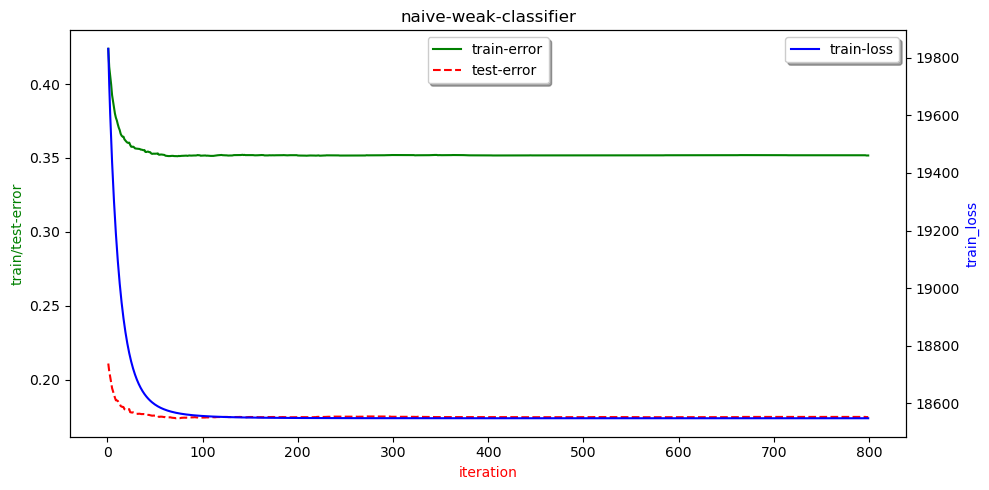

In [8]:
adaboost_object.do_plot(train_error,train_loss,test_error,test_loss)

In [9]:
w_final

array([[-4.65735379],
       [-2.95514263],
       [-2.98452129],
       [-2.30559691],
       [-0.88615988],
       [-4.48458723],
       [-1.06139316],
       [ 0.38646725],
       [-0.62110924],
       [-1.84657456],
       [-0.98910312],
       [ 0.53757836],
       [ 1.18222579],
       [ 0.64815718],
       [ 1.24316345],
       [ 1.18567885],
       [ 2.95135176],
       [-1.5919721 ],
       [-1.06729252],
       [-1.03450376],
       [-1.02263989],
       [-0.93866545],
       [-0.28645191]])